## Analiza lagu hydrologicznego na podstawie kilku wybranych stacji

In [30]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imgw_api import get_hydro_metadata,get_meteo_metadata
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler

### Wczytanie danych

In [2]:
meteo = pd.read_parquet("../static_data/filtered_meteo_opad_data.parquet.gzip")
hydro = pd.read_parquet("../static_data/filtered_hydro_data.parquet.gzip")

In [3]:
meteo_meta = get_meteo_metadata(True)
hydro_meta = get_hydro_metadata(True)

Kody stacji hydrologicznych wybranych do analizy (w notatniku Analiza poziomu wody).

In [4]:
hydro_stations = [150200090, 149200100, 150210130, 149180090, 149200170]

### Odnalezienie nalbliższych stacji meteorologicznych do wybranych stacji hydrologicznych

In [6]:
stations_h = []
stations_m = []
for station in hydro_stations:
    stations_h.append(hydro_meta[hydro_meta['Station Code']==station])
    stations_m.append(meteo_meta[meteo_meta['Station Code']== gpd.sjoin_nearest(left_df = hydro_meta[hydro_meta['Station Code']==station], right_df = meteo_meta).iloc[0]['Station Code_right']])
    #obiczć kor dla lagów
    # na wykresie
stations_h = gpd.GeoDataFrame(pd.concat(stations_h, ignore_index=True), crs=hydro_meta.crs)
stations_m = gpd.GeoDataFrame(pd.concat(stations_m, ignore_index=True), crs=meteo_meta.crs)

In [169]:
stations_h

,Station Code,Station Name,Lon,Lat,geometry
0,150200090,SŁOWIK,20.536111,50.832778,POINT (608140.205 330663.421)
1,149200100,ŁYSA POLANA,20.115000,49.263611,POINT (581097.554 155721.103)
2,150210130,PUSTKÓW,21.465000,50.143333,POINT (676071.051 255808.575)
3,149180090,MIZERÓW-BORKI,18.768611,49.998889,POINT (483421.63 236870.603)
4,149200170,PROSZÓWKI,20.438333,49.996389,POINT (603056.034 237558.035)


In [167]:
stations_m

,Station Code,Station Name,Lon,Lat,geometry
0,250200010,BARTKÓW,20.649722,50.978611,POINT (615775.488 347046.533)
1,249200450,BIAŁKA TATRZAŃSKA,20.107222,49.412222,POINT (580289.707 172228.721)
2,250210230,RADOMYŚL WIELKI,21.269722,50.199722,POINT (661933.25 261632.962)
3,249180020,WARSZOWICE,18.705556,49.991944,POINT (478900.884 236114.541)
4,249200060,GNOJNIK,20.588333,49.895278,POINT (614041.544 226537.755)


### Wizualizacja wybranych stacji

Kody wybranych stacji:
- Pólnoc:
    - hydro: 150200090
    - meteo: 250200010
- Poudnie:
    - hydro: 149200100
    - meteo: 249200450
- Zachód:
    - hydro: 149180090
    - meteo: 249180020
- Wschód:
    - hydro: 150210130
    - meteo: 250210230
- Centrum:
    - hydro: 149200170
    - meteo: 249200060

In [7]:
zlewnie = gpd.read_file('../static_data/zlewnie/zlewnie_2.gpkg')

/var/folders/z9/f473nv411j13cywwsnc_vt580000gn/T/ipykernel_66280/4179157125.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


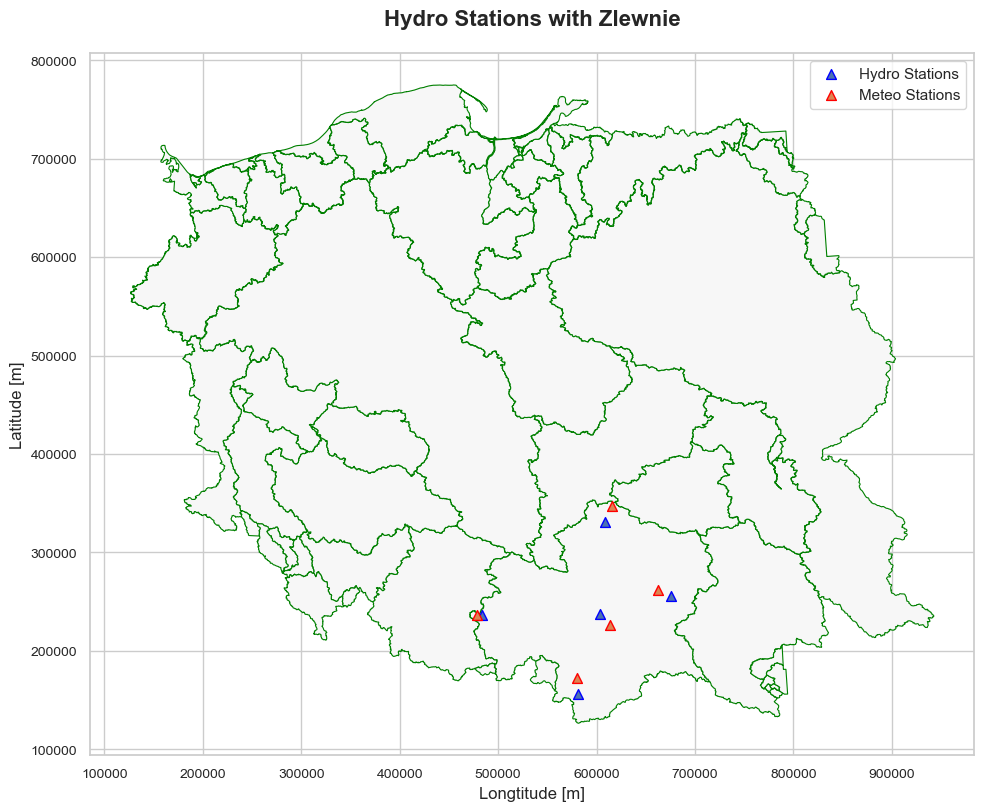

In [20]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

zlewnie.plot(ax=ax,color="#f7f7f7",edgecolor="green", linewidth=0.8, label='Zlewnie')
stations_h.plot(ax=ax, edgecolor="blue", marker='^', markersize=50, label='Hydro Stations')
stations_m.plot(ax=ax, edgecolor="red", marker='^', markersize=50, label='Meteo Stations')

ax.set_title("Hydro Stations with Zlewnie", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Longtitude [m]", fontsize=12)
ax.set_ylabel("Latitude [m]", fontsize=12)
ax.tick_params(labelsize=10)
ax.legend()

plt.tight_layout()
plt.show()

### Analiza lagu

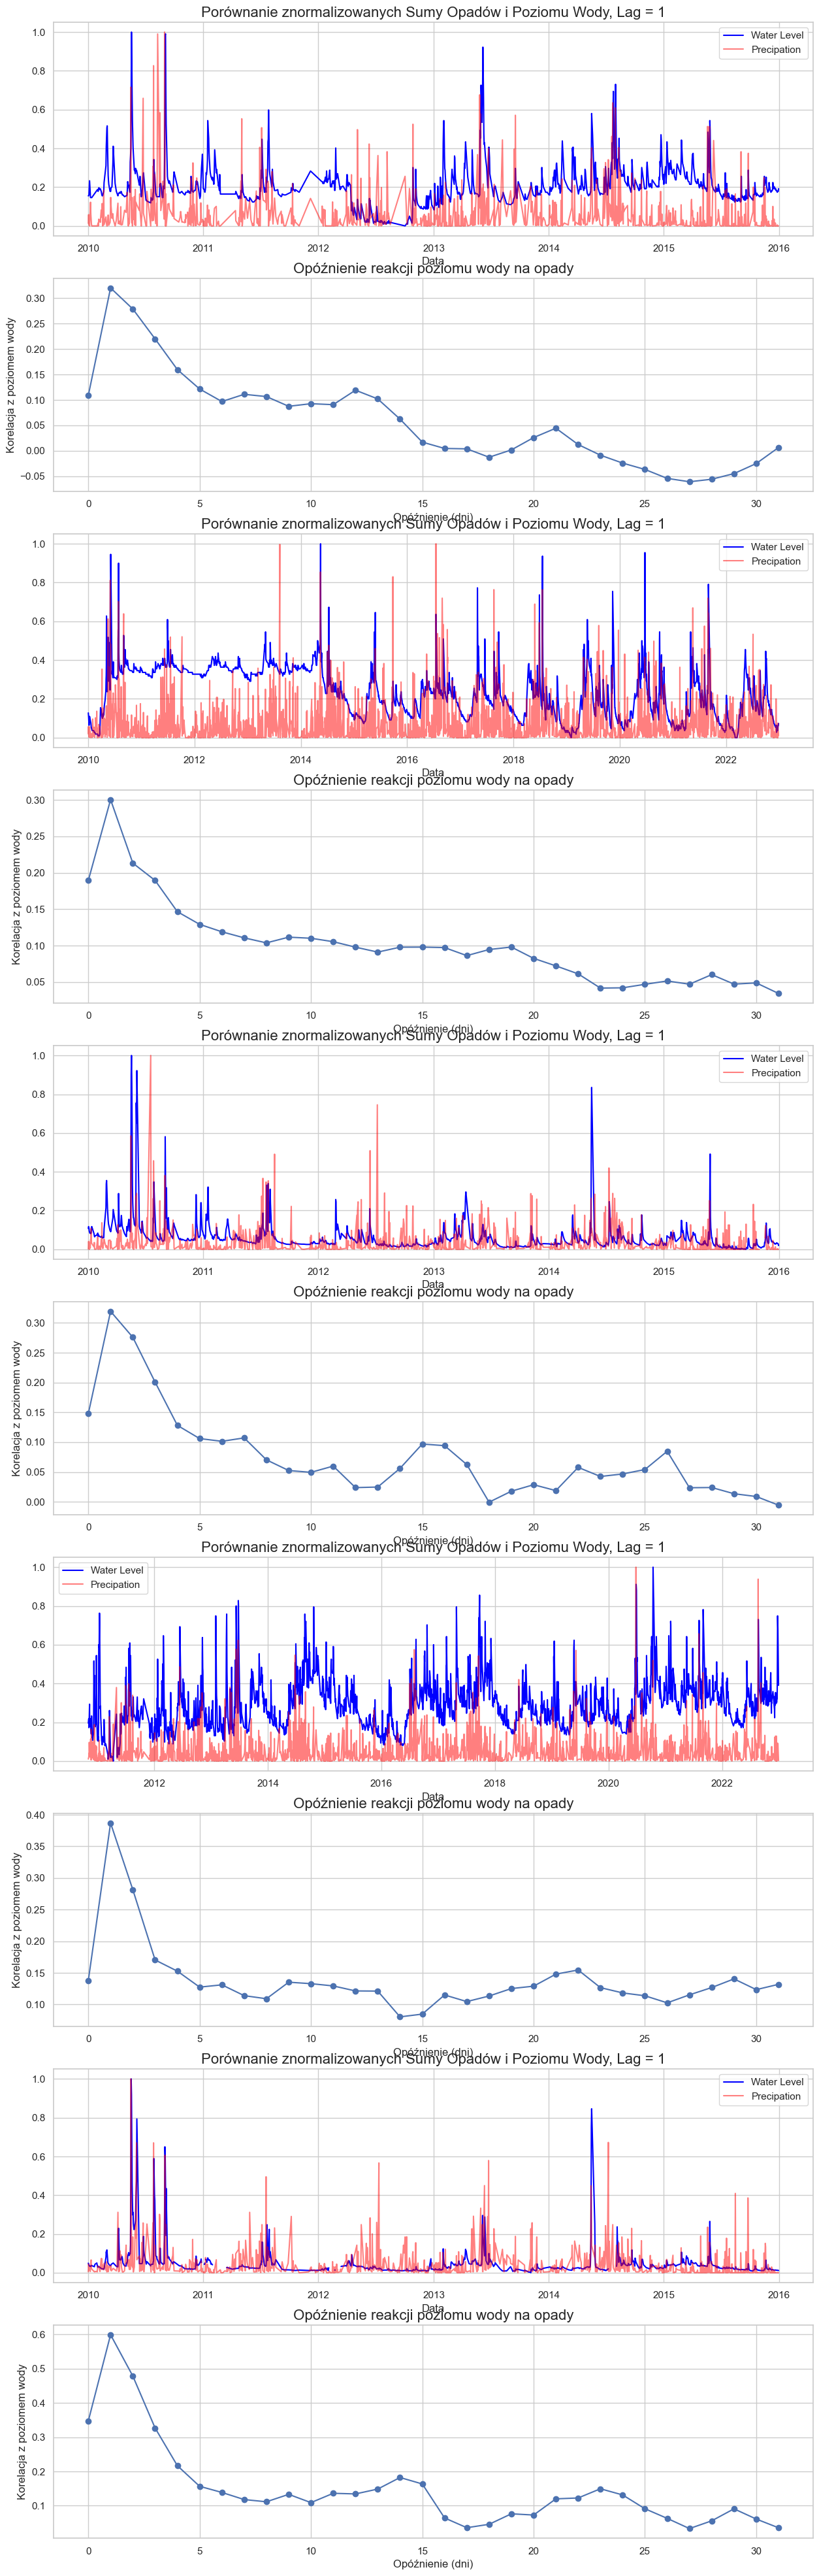

In [161]:
fig, ax = plt.subplots(10, 1, figsize=(15, 50))
k=0
max_lag = 31
for i in range(5):
    h = hydro[hydro['Station Code'] == stations_h.iloc[i]['Station Code']]
    m = meteo[meteo['Station Code'] == stations_m.iloc[i]['Station Code']]

    scaler = MinMaxScaler()
    df = pd.merge(m[['Daily Precip Sum', 'Calendar Date']], h[['Water Level', 'Calendar Date']], on="Calendar Date", how="inner")
    
    df['Daily Precip Sum'] = scaler.fit_transform(df[['Daily Precip Sum']])
    df['Water Level'] = scaler.fit_transform(df[['Water Level']])
    
    correlations=[]
    for lag in range(0, max_lag + 1):
        shifted_precip = df["Daily Precip Sum"].shift(lag)
        corr = shifted_precip.corr(df["Water Level"])
        correlations.append((lag, corr))
    best_lag, best_corr = max(correlations, key=lambda x: abs(x[1]))
    lags, corr_vals = zip(*correlations)
    
    ax[k].plot(df["Calendar Date"],df["Water Level"],color='blue',label="Water Level")
    ax[k].plot(df["Calendar Date"],df["Daily Precip Sum"],color='red',label="Precipation", alpha = 0.5)
    ax[k].set_title(f'Porównanie znormalizowanych Sumy Opadów i Poziomu Wody, Lag = {best_lag}', fontsize=16)
    ax[k].set_xlabel('Data', fontsize=12)
    ax[k].legend()

    ax[k+1].plot(lags, corr_vals, marker='o')
    ax[k+1].set_title("Opóźnienie reakcji poziomu wody na opady", fontsize=16)
    ax[k+1].set_xlabel("Opóźnienie (dni)", fontsize=12)
    ax[k+1].set_ylabel("Korelacja z poziomem wody")
    k+=2
    


### Wnioski
Dla wszystkich wybranych stacji, w obrębie tej zlewni, zaobserwowano krótki lag, co jest charakterystyczne dla terenów górskich.
W każdej z nich nasilniejszy spadek korelacji widoczny jest w ciągu 5 dni. W tym czasie wpływ opadów na poziom wody praktycznie zanika.